In [2]:
import geopandas as gpd 
import pandas as pd
from shapely import ops
import os
import shapely
import numpy as np
import psycopg2
import networkx as nx
import multiprocessing as mp
from shapely.geometry import LineString
import pandana as pdna
from pandana import Network
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
shapely.speedups.enable()

%matplotlib inline 

In [2]:
def create_graph(gdf, precision=9, simplify=1):
    '''Create a networkx DiGraph given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
    # The geometries sometimes have tiny end parts - get rid of those!
    gdf.geometry = gdf.geom.simplify(simplify)

    #G = nx.DiGraph()
    G = nx.Graph()

    # TODO: converting to string is probably unnecessary - keeping float may be
    # faster
    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    # az1 is the azimuth of the first segment of the geometry (point into the
    # geometry), az2 is for the last segment (pointing out of the geometry)
    def add_edges(row, G):
        geom = row.geom
        coords = list(geom.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
        fwd_attr['geometry']=  geom
        fwd_attr['length']=  geom.length
#         fwd_attr['az1']=  azimuth_cartesian(coords[0], coords[1])
#         fwd_attr['az2']=  azimuth_cartesian(coords[-2], coords[-1])
        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

### Load the Dataset

Here we will be using the created "pedestrian network" dataset created by the DAV team at the City of Toronto. We'll then create a network using the Networkx library and the "create_graph" function defined in this notebook. 



In [3]:
#pwd = open("./password",'r').readline()

con = psycopg2.connect(database="walkability", user="postgres", password=1234,
    host="172.19.118.205",port="5432")
pednet= gpd.read_postgis('SELECT * FROM compliance.att_pednet_all_in',con)



#G = create_graph(pednet)
#from G to urbanaccess network model - one node idx,x,y one edge from to weight
0

0

In [4]:
G.edges(data=True)

NameError: name 'G' is not defined

### Take the graph and setup dataframe to load into Urban Access object.

In [6]:
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [7]:
for ix, node in nodes.iterrows():
    indicies = edges[edges.to == node.xy].index
    edges.loc[indicies,'to'] = ix
    indicies = edges[edges['from'] == node.xy].index
    edges.loc[indicies,'from'] = ix

### Create the pandana network with the dataframe - using integer id's for nodes to/from

### Save the network to load again later

In [90]:
#transit_ped_net.save_hdf5('/media/DATADRIVE/walkability/ped_net_final_.hd5')
#Network.from_hdf5('/media/DATADRIVE/walkability/ped_net_final_.hd5')

FOLLOW THIS TUTORIAL
--Load building centroids

http://udst.github.io/pandana/tutorial.html

In [5]:
ped_net = Network.from_hdf5('/media/DATADRIVE/walkability/ped_net_final_.hd5')
store = pd.HDFStore('/media/DATADRIVE/walkability/ped_net_final_.hd5')

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


In [30]:
#ped_net = Network.from_hdf5('/media/DATADRIVE/walkability/ablajan/ped_net2019.h5')
#ped_net = pd.HDFStore('/media/DATADRIVE/walkability/ablajan/ped_net2019.h5')
nodes = store.nodes
edges = store.edges
print(nodes.head(3))
print(edges.head(3))


             x             y
0  326667.2440  4.845234e+06
1  294723.3043  4.845668e+06
2  314267.7206  4.835759e+06
    from     to      length
0  40338  43853   95.742874
1  40338  42804   65.894771
2  40338  12040  124.472052


In [7]:
nodes.head()

,x,y
0,326667.244000,4.845234e+06
1,294723.304300,4.845668e+06
2,314267.720600,4.835759e+06
3,325946.636500,4.846465e+06
4,311105.405213,4.836622e+06


In [15]:
#transit_ped_net = pdna.Network(nodes["x"],
#                               nodes["y"],
#                               edges["from"],
#                               edges["to"],                          
 #                              pd.DataFrame([edges.length]).T,
#                               twoway=True)

In [26]:
edges["weight"]=pd.DataFrame([edges.length]).T
#print(edges["weight"])

In [10]:
ped_net.precompute(3000)

In [9]:
schools = gpd.read_postgis('SELECT * FROM compliance.school',con)
schools.head(3)

,objectid,geo_id,name,school_level,school_type,board_name,school_type_desc,address_point_id,address_number,linear_name_full,...,lo_num,lo_num_suf,hi_num,hi_num_suf,linear_name_id,x,y,latitude,longitude,geom
0,1,565242.0,BREBEUF COLLEGE SCHOOL,None,ES,Toronto Catholic District School Board,English Separate,565242,211,Steeles Ave E,...,211,None,NaN,None,6792.0,312586.416,4851066.111,43.801525,-79.403041,POINT (312586.416 4851066.111)
1,2,11467213.0,BRIAN PUBLIC SCHOOL,None,EP,Toronto District School Board,English Public,11467213,95,Brian Dr,...,95,None,NaN,None,5028.0,318322.519,4848875.872,43.781728,-79.331810,POINT (318322.519 4848875.872)
2,3,8344927.0,BRIARCREST JUNIOR SCHOOL,None,EP,Toronto District School Board,English Public,8344927,60,Wellesworth Dr,...,60,None,NaN,None,2752.0,298326.459,4836061.171,43.666466,-79.580075,POINT (298326.459 4836061.171)


In [10]:
schools.crs = {'init' :'epsg:2019'}

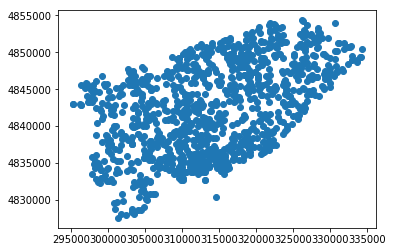

In [10]:
schools.crs
ax = schools.plot()

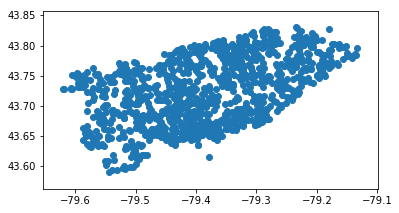

In [388]:
#schools = schools.to_crs({'init': 'epsg:4326'}) # schools.to_crs(epsg=4326) 
#ax = schools.plot()

In [11]:
ped_net.set_pois("school", 2000, 10, schools.x, schools.y)
a = ped_net.nearest_pois(2000, "school", num_pois=10)
print(a.head(5))


/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


            1            2            3            4            5   \
0   444.161987   940.244019  1035.176025  1375.994995  1545.625000   
1  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
2   446.994995   446.994995   470.369995   678.700989   696.406006   
3   401.467987   793.224976   819.742981   964.244019  1220.619019   
4   409.893005   409.893005   636.361023   718.510010   867.739014   

            6            7            8            9            10  
0  1774.187988  1776.797974  1894.280029  2000.000000  2000.000000  
1  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  
2   721.973999   778.505005   799.192017   857.434021   935.478027  
3  1233.426025  1368.946045  1547.147949  1650.906982  1658.625977  
4   958.129028  1059.756958  1125.818970  1189.734009  1189.734009  


ValueError: c of shape (63217, 10) not acceptable as a color sequence for x with size 63217, y with size 63217

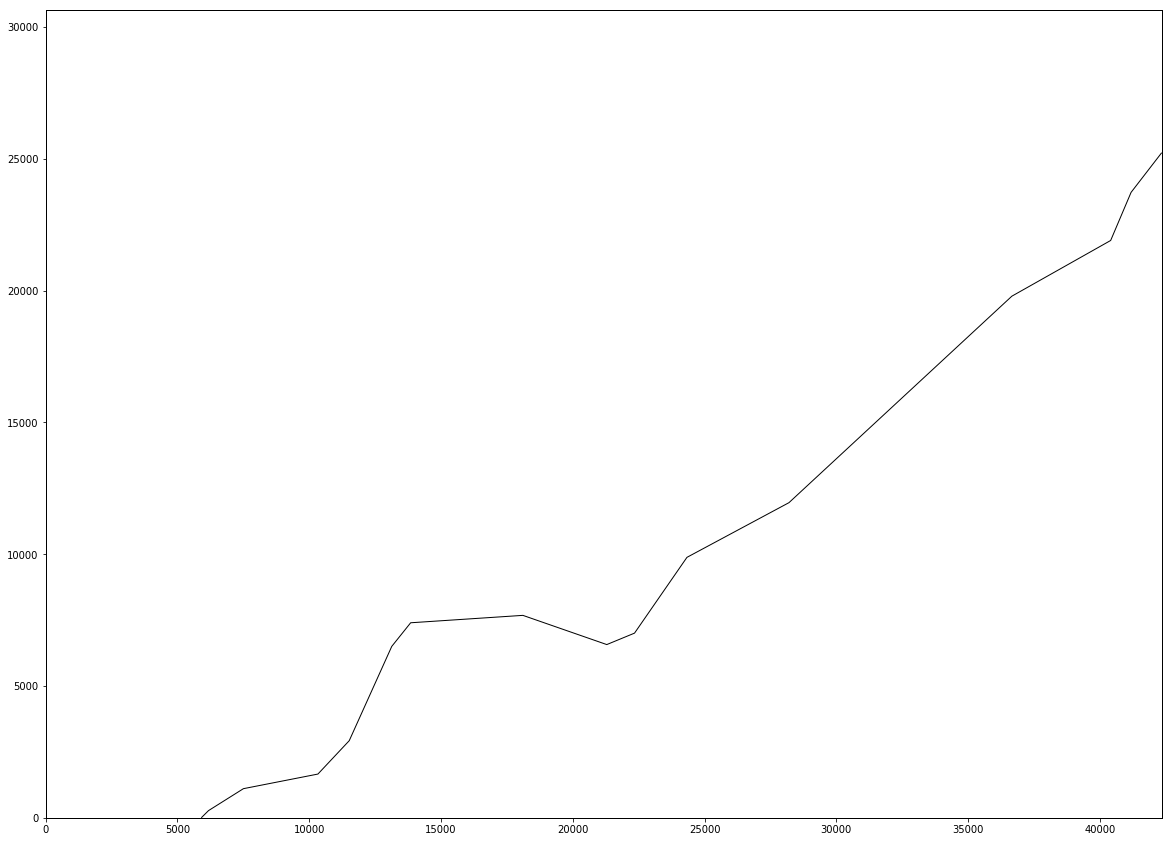

In [15]:
#Assign variables
tmp = [-79.639273,43.580253,-79.113219,43.855442]

# Reordered for Pandana functions
bbox = [tmp[1], tmp[0], tmp[3], tmp[2]]
ped_net.plot(a, bbox=bbox,
         fig_kwargs={'figsize': [20, 20]},
         bmap_kwargs={'suppress_ticks': False,
                      'resolution': 'h', 'epsg': '2019'},
         plot_kwargs={'cmap': 'BrBG', 's': 8, 'edgecolor': 'none'})

In [12]:
# set the Pandana network with this new dataset
#ped_net.set(ped_net.get_node_ids(schools.longitude, schools.latitude), name='schools.name')
#s = ped_net.aggregate(500, type='sum', decay='linear', name='school')
ped_net.poi_category_names

['school']

In [13]:
nodes = ped_net.nodes_df
edges = ped_net.edges_df
print(nodes.head())
print(edges.head())


               x             y
0  326667.244000  4.845234e+06
1  294723.304300  4.845668e+06
2  314267.720600  4.835759e+06
3  325946.636500  4.846465e+06
4  311105.405213  4.836622e+06
    from     to      length
0  40338  43853   95.742874
1  40338  42804   65.894771
2  40338  12040  124.472052
3  43853   1654   73.773739
4  43853  36758   71.306710


In [14]:
x, y = schools.x, schools.y #(schools.longitude, schools.latitude)
schools["node_ids"] = ped_net.get_node_ids(schools.x, schools.y)
schools.head(3)

/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


,objectid,geo_id,name,school_level,school_type,board_name,school_type_desc,address_point_id,address_number,linear_name_full,...,lo_num_suf,hi_num,hi_num_suf,linear_name_id,x,y,latitude,longitude,geom,node_ids
0,1,565242.0,BREBEUF COLLEGE SCHOOL,None,ES,Toronto Catholic District School Board,English Separate,565242,211,Steeles Ave E,...,None,NaN,None,6792.0,312586.416,4851066.111,43.801525,-79.403041,POINT (312586.416 4851066.111),3831
1,2,11467213.0,BRIAN PUBLIC SCHOOL,None,EP,Toronto District School Board,English Public,11467213,95,Brian Dr,...,None,NaN,None,5028.0,318322.519,4848875.872,43.781728,-79.331810,POINT (318322.519 4848875.872),13869
2,3,8344927.0,BRIARCREST JUNIOR SCHOOL,None,EP,Toronto District School Board,English Public,8344927,60,Wellesworth Dr,...,None,NaN,None,2752.0,298326.459,4836061.171,43.666466,-79.580075,POINT (298326.459 4836061.171),3406


In [31]:
s = ped_net.aggregate(500, type="sum", decay="linear", name="school")
t = ped_net.aggregate(1000, type="sum", decay="linear", name="school")
u = ped_net.aggregate(2000, type="sum", decay="linear", name="school")
v = ped_net.aggregate(3000, type="sum", decay="linear", name="school")
w = ped_net.aggregate(3000, type="ave", decay="flat",   name="school")

In [15]:
ped_net.set_pois("schools", 2000, 10, x, y)
npi = ped_net.nearest_pois(2000, "schools", num_pois=5)
npi


/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


,1,2,3,4,5
0,444.161987,940.244019,1035.176025,1375.994995,1545.625000
1,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
2,446.994995,446.994995,470.369995,678.700989,696.406006
3,401.467987,793.224976,819.742981,964.244019,1220.619019
4,409.893005,409.893005,636.361023,718.510010,867.739014
5,606.065979,1029.826050,1237.525024,1733.767944,1753.329956
6,166.716003,473.527008,490.407990,668.184021,720.051025
7,369.602997,562.390015,710.770020,716.151978,716.151978
8,583.474976,712.159973,743.737000,887.880005,1004.679016
9,274.502991,514.323975,819.198975,960.504028,965.273010


(<mpl_toolkits.basemap.Basemap at 0x7f99cd498978>,
 <Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa21af09e10>)

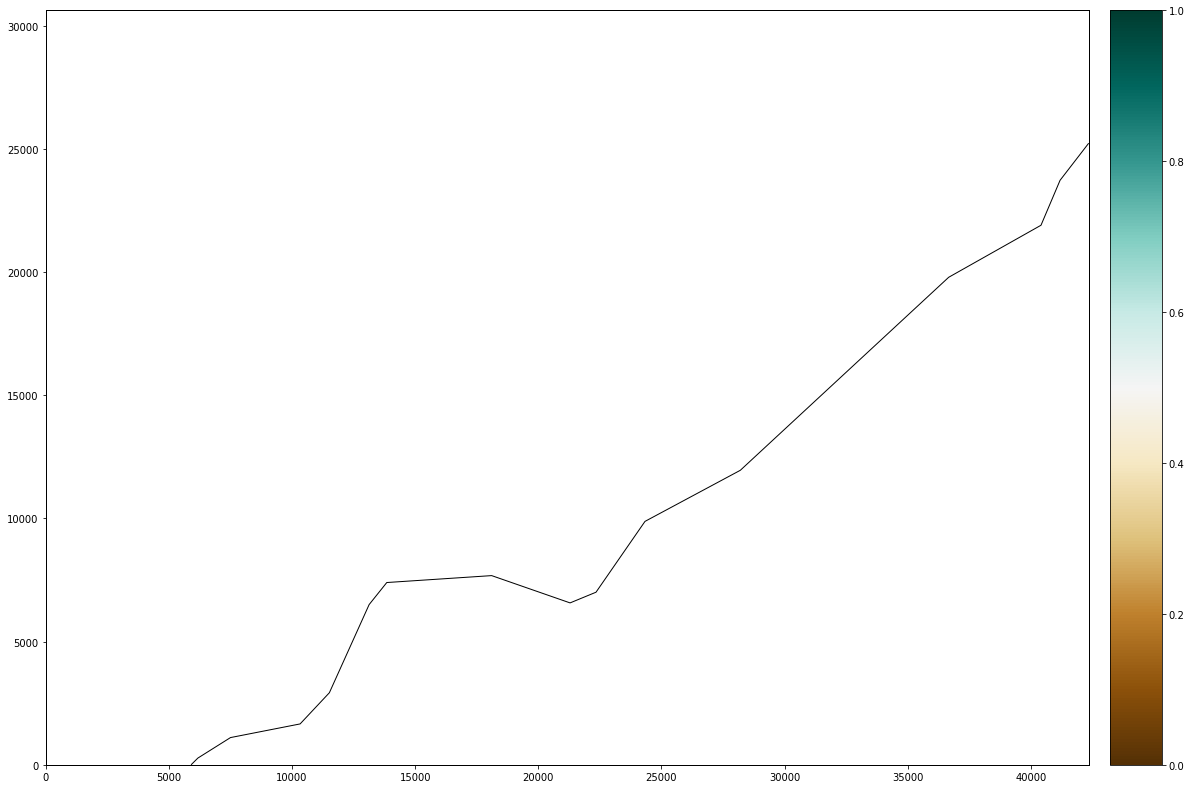

In [227]:
w = ped_net.aggregate(3000, type="ave", decay="flat", name="schools")
#Assign variables
tmp = [-79.639273,43.580253,-79.113219,43.855442]

# Reordered for Pandana functions
bbox = [tmp[1], tmp[0], tmp[3], tmp[2]]
ped_net.plot(w, bbox=bbox,
         fig_kwargs={'figsize': [20, 20]},
         bmap_kwargs={'suppress_ticks': False,
                      'resolution': 'h', 'epsg': '2019'},
         plot_kwargs={'cmap': 'BrBG', 's': 8, 'edgecolor': 'none'})

In [16]:
con = psycopg2.connect(database="walkability", user="postgres", password=1234, host="172.19.118.205",port="5432")
bldg = gpd.read_postgis('SELECT * FROM public.topo_building',con)
bldg.head(3)

,gid,subtype_co,subtype_de,elevation,derived_he,derived_ow,last_geome,last_attri,x,y,longitude,latitude,shape_area,shape_len,geom
0,1,9005,Garage Separate from House,125.61,1.0,None,2005-01-01,2005-01-01,317808.797,4838938.569,-79.338428,43.692281,0.0,0.0,"(POLYGON ((317805.079 4838939.579, 317811.502 ..."
1,2,9003,Building Outline,154.79,1.0,None,2005-01-01,2005-01-01,304407.703,4843051.830,-79.504674,43.729419,0.0,0.0,"(POLYGON ((304398.216 4843059.168, 304404.92 4..."
2,3,9005,Garage Separate from House,114.67,1.0,None,2005-01-01,2005-01-01,306413.156,4834669.345,-79.479805,43.653963,0.0,0.0,"(POLYGON ((306408.68 4834670.998, 306409.516 4..."


In [320]:
#building_node_id
#net.get_node_ids(x_col = bldg.x, y_col = bldg.y )
#ped_net.set(ped_net.get_node_ids(bldg.x, bldg.y), name='building')


/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


0         13866
1          7195
2         42393
3         18222
4         33596
5          1991
6         37891
7         33843
8          1307
9         60926
10        19421
11        29302
12        42361
13         7769
14         5486
15        21003
16        54459
17         8498
18        32961
19        25615
20        33052
21        10667
22        30713
23        24742
24         4576
25        51414
26        47982
27        33316
28         9439
29        44864
          ...  
527554     7195
527555    43465
527556    52644
527557    47097
527558    10017
527559     9648
527560     4826
527561      122
527562    43465
527563    17751
527564    46919
527565    32892
527566    57411
527567    21090
527568    13096
527569    27197
527570      122
527571    35396
527572    49794
527573    45338
527574    42393
527575      122
527576    59056
527577    13866
527578    41382
527579    40032
527580    59324
527581    59124
527582     1069
527583    23145
Name: node_id, Length: 5

In [321]:
#for ped_net.get_node_ids in ped_net.node_ids:
#print(net.get_node_ids)

<bound method Network.get_node_ids of <pandana.network.Network object at 0x7f86d00a9710>>


In [373]:
#for net.get_node_ids in nodes:
 # print(edges.weight)


In [396]:
#create centroids

#bldg['centroid'] = bldg.centroid
#bldg = bldg.set_geometry('centroid')
#bldg.plot();


In [17]:
# create building centroid and get centroid_x and centroid_xy
bldg['cx'] = bldg.centroid.map(lambda p: p.x)
bldg['cy'] = bldg.centroid.map(lambda p: p.y)
bldg.head(3)

,gid,subtype_co,subtype_de,elevation,derived_he,derived_ow,last_geome,last_attri,x,y,longitude,latitude,shape_area,shape_len,geom,cx,cy
0,1,9005,Garage Separate from House,125.61,1.0,None,2005-01-01,2005-01-01,317808.797,4838938.569,-79.338428,43.692281,0.0,0.0,"(POLYGON ((317805.079 4838939.579, 317811.502 ...",317808.797370,4.838939e+06
1,2,9003,Building Outline,154.79,1.0,None,2005-01-01,2005-01-01,304407.703,4843051.830,-79.504674,43.729419,0.0,0.0,"(POLYGON ((304398.216 4843059.168, 304404.92 4...",304407.703047,4.843052e+06
2,3,9005,Garage Separate from House,114.67,1.0,None,2005-01-01,2005-01-01,306413.156,4834669.345,-79.479805,43.653963,0.0,0.0,"(POLYGON ((306408.68 4834670.998, 306409.516 4...",306413.156212,4.834669e+06


In [18]:
# get building centroid node_id

node_ids = ped_net.get_node_ids(bldg['cx'], bldg['cy'])
#node_ids = ped_net.get_node_ids(bldg['x'], bldg['y'])
bldg['node_ids'] = node_ids
bldg.head(3)

/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


,gid,subtype_co,subtype_de,elevation,derived_he,derived_ow,last_geome,last_attri,x,y,longitude,latitude,shape_area,shape_len,geom,cx,cy,node_ids
0,1,9005,Garage Separate from House,125.61,1.0,None,2005-01-01,2005-01-01,317808.797,4838938.569,-79.338428,43.692281,0.0,0.0,"(POLYGON ((317805.079 4838939.579, 317811.502 ...",317808.797370,4.838939e+06,7125
1,2,9003,Building Outline,154.79,1.0,None,2005-01-01,2005-01-01,304407.703,4843051.830,-79.504674,43.729419,0.0,0.0,"(POLYGON ((304398.216 4843059.168, 304404.92 4...",304407.703047,4.843052e+06,25061
2,3,9005,Garage Separate from House,114.67,1.0,None,2005-01-01,2005-01-01,306413.156,4834669.345,-79.479805,43.653963,0.0,0.0,"(POLYGON ((306408.68 4834670.998, 306409.516 4...",306413.156212,4.834669e+06,34748


In [671]:
#bldgdf = geopandas.GeoDataFrame(bldg, geometry='geom')
#bldgdf.plot()

In [19]:
bldg

,gid,subtype_co,subtype_de,elevation,derived_he,derived_ow,last_geome,last_attri,x,y,longitude,latitude,shape_area,shape_len,geom,cx,cy,node_ids
0,1,9005,Garage Separate from House,125.61,1.0,None,2005-01-01,2005-01-01,317808.797,4838938.569,-79.338428,43.692281,0.0,0.0,"(POLYGON ((317805.079 4838939.579, 317811.502 ...",317808.797370,4.838939e+06,7125
1,2,9003,Building Outline,154.79,1.0,None,2005-01-01,2005-01-01,304407.703,4843051.830,-79.504674,43.729419,0.0,0.0,"(POLYGON ((304398.216 4843059.168, 304404.92 4...",304407.703047,4.843052e+06,25061
2,3,9005,Garage Separate from House,114.67,1.0,None,2005-01-01,2005-01-01,306413.156,4834669.345,-79.479805,43.653963,0.0,0.0,"(POLYGON ((306408.68 4834670.998, 306409.516 4...",306413.156212,4.834669e+06,34748
3,4,9005,Garage Separate from House,113.64,1.0,None,2005-01-01,2005-01-01,306414.759,4834647.332,-79.479785,43.653765,0.0,0.0,"(POLYGON ((306411.278 4834648.495, 306414.882 ...",306414.759445,4.834647e+06,34748
4,5,9005,Garage Separate from House,113.63,1.0,None,2005-01-01,2005-01-01,306443.176,4834653.310,-79.479433,43.653819,0.0,0.0,"(POLYGON ((306439.517 4834654.456, 306445.551 ...",306443.175544,4.834653e+06,2209
5,6,9005,Garage Separate from House,113.44,1.0,None,2005-01-01,2005-01-01,306778.099,4834595.143,-79.475281,43.653294,0.0,0.0,"(POLYGON ((306774.012 4834598.512, 306779.684 ...",306778.098654,4.834595e+06,59976
6,7,9005,Garage Separate from House,112.51,1.0,None,2005-01-01,2005-01-01,306789.285,4834561.391,-79.475142,43.652991,0.0,0.0,"(POLYGON ((306785.047 4834564.001, 306791.38 4...",306789.285385,4.834561e+06,59976
7,8,9005,Garage Separate from House,111.60,1.0,None,2005-01-01,2005-01-01,306870.702,4834586.146,-79.474133,43.653213,0.0,0.0,"(POLYGON ((306867.25 4834586.125, 306872.018 4...",306870.701945,4.834586e+06,34719
8,9,9005,Garage Separate from House,110.71,1.0,None,2005-01-01,2005-01-01,306417.353,4834186.923,-79.479754,43.649621,0.0,0.0,"(POLYGON ((306415.062 4834188.682, 306418.277 ...",306417.353030,4.834187e+06,40903
9,10,9005,Garage Separate from House,96.26,1.0,None,2005-01-01,2005-01-01,306092.166,4833918.656,-79.483786,43.647207,0.0,0.0,"(POLYGON ((306088.094 4833919.662, 306093.455 ...",306092.165871,4.833919e+06,56161


In [31]:
#bldg.x

In [20]:
#try to find closest node_ids between building and schools. This one find only one
from scipy.spatial import cKDTree  
def ckdnearest(bldg, schools, name):   
    nA = np.array(list(zip(bldg.x, bldg.y)) )
    nB = np.array(list(zip(schools.x, schools.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(float), 'name' : schools.loc[idx, name].values })
    return df
ckdnearest(bldg, schools, 'name')

,distance,name
0,312.683989,HOLY CROSS CATHOLIC ELEMENTARY SCHOOL
1,369.279577,TUMPANE PUBLIC SCHOOL
2,287.773549,RUNNYMEDE JUNIOR & SENIOR PUBLIC SCHOOL
3,303.839535,RUNNYMEDE JUNIOR & SENIOR PUBLIC SCHOOL
4,282.368485,RUNNYMEDE JUNIOR & SENIOR PUBLIC SCHOOL
5,271.907302,HUMBERSIDE MONTESSORI
6,237.246047,HUMBERSIDE MONTESSORI
7,261.939208,OXFORD LEARNING CENTRE - HIGH PARK
8,414.277129,HUMBERSIDE MONTESSORI
9,458.370405,ST PIUS X CATHOLIC ELEMENTARY SCHOOL


In [21]:
from scipy.spatial import cKDTree  
def ckdnearest(gdA, gdB, name, bdnode, scnode):   
    nA = np.array(list(zip(gdA.x, gdA.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(float), 'name' : gdB.loc[idx, name].values, 'bdnode': gdA.node_ids.astype(int), 'scnode': gdB.node_ids.astype(float).astype(int) })
    return df
ckdnearest(bldg, schools, 'name', 'bdnode', 'scnode')




,distance,name,bdnode,scnode
0,312.683989,HOLY CROSS CATHOLIC ELEMENTARY SCHOOL,7125,3831.0
1,369.279577,TUMPANE PUBLIC SCHOOL,25061,13869.0
2,287.773549,RUNNYMEDE JUNIOR & SENIOR PUBLIC SCHOOL,34748,3406.0
3,303.839535,RUNNYMEDE JUNIOR & SENIOR PUBLIC SCHOOL,34748,35682.0
4,282.368485,RUNNYMEDE JUNIOR & SENIOR PUBLIC SCHOOL,2209,15114.0
5,271.907302,HUMBERSIDE MONTESSORI,59976,21565.0
6,237.246047,HUMBERSIDE MONTESSORI,59976,41017.0
7,261.939208,OXFORD LEARNING CENTRE - HIGH PARK,34719,53108.0
8,414.277129,HUMBERSIDE MONTESSORI,40903,11473.0
9,458.370405,ST PIUS X CATHOLIC ELEMENTARY SCHOOL,56161,58066.0


In [22]:
bldg.node_ids.unique 

<bound method Series.unique of 0          7125
1         25061
2         34748
3         34748
4          2209
5         59976
6         59976
7         34719
8         40903
9         56161
10        52673
11         2037
12        52314
13        26735
14        34748
15        12051
16        12051
17         2209
18        24865
19        57452
20        31362
21        31362
22        40277
23        53450
24        11157
25        14089
26        25114
27        25114
28         5822
29        18781
          ...  
527554    48407
527555    36639
527556    39494
527557    30045
527558    17436
527559     8860
527560    23910
527561    13588
527562     3523
527563    56414
527564    15495
527565    39581
527566    53045
527567    23090
527568    47408
527569    16114
527570    51739
527571    21564
527572    52100
527573    36193
527574    43632
527575    43632
527576    55957
527577    33667
527578     3741
527579    38792
527580    13248
527581    37176
527582    30312
527583   

In [28]:
#http://172.19.118.205:8000/user/asulaim/notebooks/production/projects/walkability/code/UrbanAccess-abj.ipynb#
building_ped_net = pdna.Network(bldg["cx"],
                               bldg["cy"],
                               edges["from"],
                               edges["to"],                          
                               edges[["weight"]],
                               twoway=True)

/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


In [609]:
building_ped_net.edges_df
building_ped_net.nodes_df


In [29]:
building_ped_net.set_pois("schools", 2000, 10, x, y)
building_ped_net.nearest_pois(2000, "schools", num_pois=10)

/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


,1,2,3,4,5,6,7,8,9,10
0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0
1,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0
2,575.182983,1545.162964,1876.019043,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0
3,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0
4,857.887024,1265.946045,1265.946045,1872.026001,1872.026001,1949.197998,2000.000000,2000.000000,2000.0,2000.0
5,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0
6,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0
7,1304.782959,1966.644043,1966.644043,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0
8,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0
9,1922.156982,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0


In [ ]:
building_ped_net.

In [106]:
bldg.node_ids.describe()

count    527584.000000
mean      31703.528682
std       18249.771558
min           0.000000
25%       15881.750000
50%       31809.000000
75%       47486.000000
max       63216.000000
Name: node_ids, dtype: float64

In [107]:
schools.node_ids.describe()

count     1130.000000
mean     31563.413274
std      18402.945359
min         50.000000
25%      16467.750000
50%      31104.000000
75%      48044.000000
max      63214.000000
Name: node_ids, dtype: float64

In [108]:
#bldg.node_ids
schools.node_ids

0        3831
1       13869
2        3406
3       35682
4       15114
5       21565
6       41017
7       53108
8       11473
9       58066
10       5320
11      23910
12      45338
13      26772
14      19956
15        821
16      55190
17      12110
18      13898
19      49778
20       1281
21      23949
22      36637
23      46405
24      51153
25      56592
26      26143
27      40835
28       4917
29        191
        ...  
1100    39848
1101    50736
1102    41639
1103    23732
1104    18693
1105     4607
1106    21565
1107    50437
1108    58458
1109    26050
1110    35500
1111    51152
1112    53354
1113    53140
1114    18270
1115    12139
1116     8585
1117     3326
1118    60489
1119    35419
1120    59978
1121    33279
1122     6578
1123    19932
1124    52437
1125      191
1126    23234
1127    54401
1128    44210
1129    58691
Name: node_ids, Length: 1130, dtype: int64

In [31]:
pnode = ped_net.nodes_df
pnode.head(3)

,x,y
0,326667.2440,4.845234e+06
1,294723.3043,4.845668e+06
2,314267.7206,4.835759e+06


In [33]:
pedges = ped_net.edges_df
pedges.head(3)

,from,to,length
0,40338,43853,95.742874
1,40338,42804,65.894771
2,40338,12040,124.472052


In [36]:
bldg.head(3)

,gid,subtype_co,subtype_de,elevation,derived_he,derived_ow,last_geome,last_attri,x,y,longitude,latitude,shape_area,shape_len,geom,cx,cy,node_ids
0,1,9005,Garage Separate from House,125.61,1.0,None,2005-01-01,2005-01-01,317808.797,4838938.569,-79.338428,43.692281,0.0,0.0,"(POLYGON ((317805.079 4838939.579, 317811.502 ...",317808.797370,4.838939e+06,7125
1,2,9003,Building Outline,154.79,1.0,None,2005-01-01,2005-01-01,304407.703,4843051.830,-79.504674,43.729419,0.0,0.0,"(POLYGON ((304398.216 4843059.168, 304404.92 4...",304407.703047,4.843052e+06,25061
2,3,9005,Garage Separate from House,114.67,1.0,None,2005-01-01,2005-01-01,306413.156,4834669.345,-79.479805,43.653963,0.0,0.0,"(POLYGON ((306408.68 4834670.998, 306409.516 4...",306413.156212,4.834669e+06,34748


In [37]:
schools.head(3)

,objectid,geo_id,name,school_level,school_type,board_name,school_type_desc,address_point_id,address_number,linear_name_full,...,lo_num_suf,hi_num,hi_num_suf,linear_name_id,x,y,latitude,longitude,geom,node_ids
0,1,565242.0,BREBEUF COLLEGE SCHOOL,None,ES,Toronto Catholic District School Board,English Separate,565242,211,Steeles Ave E,...,None,NaN,None,6792.0,312586.416,4851066.111,43.801525,-79.403041,POINT (312586.416 4851066.111),3831
1,2,11467213.0,BRIAN PUBLIC SCHOOL,None,EP,Toronto District School Board,English Public,11467213,95,Brian Dr,...,None,NaN,None,5028.0,318322.519,4848875.872,43.781728,-79.331810,POINT (318322.519 4848875.872),13869
2,3,8344927.0,BRIARCREST JUNIOR SCHOOL,None,EP,Toronto District School Board,English Public,8344927,60,Wellesworth Dr,...,None,NaN,None,2752.0,298326.459,4836061.171,43.666466,-79.580075,POINT (298326.459 4836061.171),3406


In [39]:
#bldg[bldg['node_ids']=='7125'] 
'7125' in bldg.node_ids.values

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


False

In [50]:
ped_net.net.shortest_path( 7125, 3831)

[7125,
 51852,
 50517,
 21397,
 15585,
 6313,
 21759,
 17938,
 5674,
 9112,
 43861,
 43677,
 39217,
 55487,
 34553,
 55061,
 17442,
 4587,
 14847,
 60919,
 35873,
 54558,
 9802,
 16911,
 31847,
 27166,
 57134,
 51717,
 19241,
 45718,
 14197,
 49834,
 25375,
 41603,
 50841,
 39423,
 40568,
 1159,
 7770,
 35707,
 32366,
 52690,
 56465,
 11598,
 26396,
 40471,
 10788,
 7798,
 61722,
 24872,
 41723,
 56615,
 8979,
 24665,
 41602,
 56505,
 4633,
 856,
 49610,
 6582,
 9478,
 14140,
 38380,
 32230,
 58430,
 42752,
 29263,
 25493,
 24721,
 9385,
 32507,
 7878,
 24635,
 37617,
 44773,
 32754,
 50882,
 3469,
 16954,
 43790,
 58190,
 35261,
 3632,
 9039,
 53993,
 50854,
 16974,
 11453,
 31431,
 713,
 35276,
 5091,
 146,
 42080,
 9366,
 29931,
 33726,
 47903,
 42814,
 956,
 44451,
 47722,
 29216,
 38971,
 28612,
 20080,
 62647,
 39085,
 46405,
 23059,
 35685,
 44410,
 56865,
 16857,
 34597,
 59205,
 26189,
 20414,
 31236,
 34799,
 61046,
 62240,
 35773,
 54801,
 59095,
 27487,
 12936,
 18466,
 451

In [41]:
bldg.loc[bldg['node_ids']==7125]

,gid,subtype_co,subtype_de,elevation,derived_he,derived_ow,last_geome,last_attri,x,y,longitude,latitude,shape_area,shape_len,geom,cx,cy,node_ids
0,1,9005,Garage Separate from House,125.61,1.0,None,2005-01-01,2005-01-01,317808.797,4838938.569,-79.338428,43.692281,0.0,0.0,"(POLYGON ((317805.079 4838939.579, 317811.502 ...",317808.797370,4.838939e+06,7125
481,482,9005,Garage Separate from House,125.22,1.0,None,2005-01-01,2005-01-01,317804.369,4838989.114,-79.338482,43.692736,0.0,0.0,"(POLYGON ((317801.306 4838989.65, 317806.742 4...",317804.368500,4.838989e+06,7125
9382,9383,9005,Garage Separate from House,125.67,1.0,None,2005-01-01,2005-01-01,317812.313,4838933.028,-79.338384,43.692231,0.0,0.0,"(POLYGON ((317809.637 4838935.579, 317813.258 ...",317812.313035,4.838933e+06,7125
14397,14398,9005,Garage Separate from House,125.99,1.0,None,2005-01-01,2005-01-01,317803.511,4838956.467,-79.338493,43.692442,0.0,0.0,"(POLYGON ((317799.878 4838957.035, 317806.073 ...",317803.510689,4.838956e+06,7125
15524,15525,9005,Garage Separate from House,125.67,1.0,None,2005-01-01,2005-01-01,317790.973,4839002.487,-79.338648,43.692857,0.0,0.0,"(POLYGON ((317787.894 4839003.375, 317793.225 ...",317790.973128,4.839002e+06,7125
15703,15704,9005,Garage Separate from House,125.63,1.0,None,2005-01-01,2005-01-01,317793.245,4838993.643,-79.338620,43.692777,0.0,0.0,"(POLYGON ((317789.705 4838994.41, 317795.863 4...",317793.245303,4.838994e+06,7125
33104,33105,9005,Garage Separate from House,125.26,1.0,None,2005-01-01,2005-01-01,317806.983,4838980.460,-79.338449,43.692658,0.0,0.0,"(POLYGON ((317803.834 4838981.222, 317809.256 ...",317806.982669,4.838980e+06,7125
33105,33106,9005,Garage Separate from House,125.84,1.0,None,2005-01-01,2005-01-01,317807.285,4838947.882,-79.338446,43.692365,0.0,0.0,"(POLYGON ((317804.128 4838949.004, 317809.487 ...",317807.284794,4.838948e+06,7125
34127,34128,9005,Garage Separate from House,125.74,2.0,None,2005-01-01,2005-01-01,317798.120,4838975.265,-79.338559,43.692612,0.0,0.0,"(POLYGON ((317794.149 4838976.081, 317800.915 ...",317798.119806,4.838975e+06,7125
34128,34129,9005,Garage Separate from House,125.87,2.0,None,2005-01-01,2005-01-01,317800.472,4838967.801,-79.338530,43.692544,0.0,0.0,"(POLYGON ((317795.943 4838970.225, 317802.776 ...",317800.471500,4.838968e+06,7125


In [35]:
ped_net.net.shortest_path_distance(7125, 34748)

13463.387

In [36]:
schools.node_ids = schools.node_ids.astype(int)
bldg.node_ids = bldg.node_ids.astype(int)

In [37]:
i = 0 
list = []
for i in range(len(schools)):
    distance = ped_net.net.shortest_path_distance(7125, schools.node_ids[i])
    list.append([distance, schools.node_ids[i]])

pd.DataFrame(list)


,0,1
0,15104.505,3831
1,11458.759,13869
2,21905.890,3406
3,12118.784,35682
4,18055.977,15114
5,21494.371,21565
6,7838.830,41017
7,10567.365,53108
8,9872.780,11473
9,14969.171,58066


In [39]:
import time
start = time.time()
j = 0 
list = []
for j in range(len(bldg)):
    distant = ped_net.net.shortest_path_distance(bldg.node_ids[j], 3831)
    list.append([distant, bldg.node_ids[j]])

pd.DataFrame(list)
end = time.time()
print(end - start)

38.322696685791016


In [125]:
schools['node_ids']

0        3831
1       13869
2        3406
3       35682
4       15114
5       21565
6       41017
7       53108
8       11473
9       58066
10       5320
11      23910
12      45338
13      26772
14      19956
15        821
16      55190
17      12110
18      13898
19      49778
20       1281
21      23949
22      36637
23      46405
24      51153
25      56592
26      26143
27      40835
28       4917
29        191
        ...  
1100    39848
1101    50736
1102    41639
1103    23732
1104    18693
1105     4607
1106    21565
1107    50437
1108    58458
1109    26050
1110    35500
1111    51152
1112    53354
1113    53140
1114    18270
1115    12139
1116     8585
1117     3326
1118    60489
1119    35419
1120    59978
1121    33279
1122     6578
1123    19932
1124    52437
1125      191
1126    23234
1127    54401
1128    44210
1129    58691
Name: node_ids, Length: 1130, dtype: int64

In [132]:
#query takes too much time. 
i = 0
j = 0
result = []
for i, row in bldg.iterrows():
    bldgnid = bldg.node_ids[i]
    #print(bldgnid)
    for j, row in schools.iterrows():
        scnid = schools.node_ids[j]
        #print(scnid)
        if j > 0:
            
        #print('bldg.node_ids', 'schools.node_ids')
            distance = ped_net.net.shortest_path_distance(bldgnid, scnid)
            result.append(distance) 


KeyboardInterrupt: 

In [141]:
import time
start = time.time()
i = 0
j = 0
result = []
for j, row in schools.iterrows():
        scnid = schools.node_ids[j]
        result.append(scnid) 
print(result) 
end = time.time()
print(end - start)

[3831, 13869, 3406, 35682, 15114, 21565, 41017, 53108, 11473, 58066, 5320, 23910, 45338, 26772, 19956, 821, 55190, 12110, 13898, 49778, 1281, 23949, 36637, 46405, 51153, 56592, 26143, 40835, 4917, 191, 34607, 54428, 3024, 38694, 25744, 30825, 26302, 56418, 48763, 55659, 58856, 60062, 11063, 61598, 27606, 59775, 54096, 32049, 1587, 61631, 7032, 17542, 7810, 32865, 33802, 56466, 27089, 55164, 3922, 20960, 12690, 23352, 18328, 57530, 59538, 44857, 33992, 26226, 56247, 18838, 33078, 34818, 7657, 14813, 54169, 28718, 1725, 9385, 6822, 44660, 4959, 28538, 38777, 10342, 39148, 10462, 24990, 57600, 4567, 16417, 10105, 43135, 19906, 37557, 22696, 57237, 6873, 61664, 61342, 50404, 50633, 33747, 12899, 59216, 17834, 2784, 39330, 57876, 17319, 60236, 29151, 17319, 8710, 48254, 13544, 13418, 33199, 35721, 10746, 1587, 59591, 42128, 57323, 26707, 37764, 53230, 33865, 19452, 16617, 25741, 22844, 14840, 21950, 44796, 20030, 60592, 41725, 17901, 53380, 964, 691, 42673, 25795, 52925, 18397, 17042, 60242

In [59]:
import time
start = time.time()
i = 0
j = 0
bldgnid = 7125
resul = []
for j, row in schools.iterrows():
        scnid = schools.node_ids[j]
        dist = ped_net.net.shortest_path_distance(bldgnid, scnid)
        resul.append({'bldg_nid': bldgnid, 'school_nid': scnid, 'distance': dist }) 
d = pd.DataFrame(resul).sort_values(by=['distance'])
print(d[:5]) 
end = time.time()
print(end - start)



     bldg_nid  distance  school_nid
423      7125   464.118       15964
74       7125   567.818       54169
125      7125   744.048       53230
840      7125   930.338       48863
320      7125   948.344       31204
0.14279413223266602


In [66]:
import time
start = time.time()
i = 0
j = 0
bldgnid = 7125
resul = []
for row in schools.itertuples():
    dist = ped_net.net.shortest_path_distance(bldgnid, row.node_ids)
    resul.append({'bldg_nid': bldgnid, 'school_nid': scnid, 'distance': dist }) 
d = pd.DataFrame(resul).sort_values(by=['distance'])
print(d[:5]) 
end = time.time()
print(end - start)


     bldg_nid  distance  school_nid
423      7125   464.118       58691
74       7125   567.818       58691
125      7125   744.048       58691
840      7125   930.338       58691
320      7125   948.344       58691
0.047167301177978516


In [1]:
import time
start = time.time()
#i = 0
#j = 0
#bldgnid = 7125
resul = []
for row in bldg.itertuples():
    bldgnid = row.node_ids
    #result.append(row.node_ids)
    for row in schools.itertuples():
        scnid = row.node_ids
        dist = ped_net.net.shortest_path_distance(bldgnid, scnid)
        print(dist)
        resul.append({'bldg_nid': bldgnid, 'school_nid': scnid, 'distance': dist }) 
d = pd.DataFrame(resul).sort_values(by=['distance'])
print(d[:5]) 
end = time.time()
print(end - start)

NameError: name 'bldg' is not defined

In [142]:
import time
start = time.time()
i = 0
res = []
for i, row in bldg.iterrows():
    bldgnid = bldg.node_ids[i]
    res.append(bldgnid) 
print(res)
end = time.time()
print(end - start)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [44]:
# itertuples
import time
start = time.time()
result = []
for row in bldg.itertuples():
    result.append(row.node_ids)
end = time.time()
print(end - start)
print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [143]:
import time
start = time.time()
res = []
for row in bldg.itertuples():
    bldgnid = bldg.node_ids
    res.append(bldgnid) 
print(res)
end = time.time()
print(end - start)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#testing with range
x = bldg['node_ids']
y = schools['node_ids']
for bldg.node_ids in range(0, len(bldg.index)):
    for schools.node_ids in range(0, len(schools.index)):
        #print(bldg['node_ids'], schools['node_ids'])
        print(ped_net.net.shortest_path_distance(x, y))
    

In [54]:
bldg.index

RangeIndex(start=0, stop=527584, step=1)

In [55]:
schools.index

RangeIndex(start=0, stop=1130, step=1)

In [109]:
x = bldg['node_ids']
y = schools['node_ids']
print(y)

0        3831
1       13869
2        3406
3       35682
4       15114
5       21565
6       41017
7       53108
8       11473
9       58066
10       5320
11      23910
12      45338
13      26772
14      19956
15        821
16      55190
17      12110
18      13898
19      49778
20       1281
21      23949
22      36637
23      46405
24      51153
25      56592
26      26143
27      40835
28       4917
29        191
        ...  
1100    39848
1101    50736
1102    41639
1103    23732
1104    18693
1105     4607
1106    21565
1107    50437
1108    58458
1109    26050
1110    35500
1111    51152
1112    53354
1113    53140
1114    18270
1115    12139
1116     8585
1117     3326
1118    60489
1119    35419
1120    59978
1121    33279
1122     6578
1123    19932
1124    52437
1125      191
1126    23234
1127    54401
1128    44210
1129    58691
Name: node_ids, Length: 1130, dtype: int64


In [84]:
x = 85
y = 1008
print(ped_net.net.shortest_path_distance(x, y))

27048.631
